In [1]:
#!pip install backtrader[plotting]

In [1]:
import backtrader as bt

class MyStrategy(bt.Strategy):

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(period=15)

    def next(self):
        if self.sma > self.data.close:
            # Do something
            pass

        elif self.sma < self.data.close:
            # Do something else
            pass

Starting Portfolio Value: 100000.00
2017-01-23, Close, 207.00
rsi: 57.57575757575758
2017-01-24, Close, 206.00
rsi: 56.26423690205011
2017-01-25, Close, 207.20
rsi: 57.51489361702126
2017-01-26, Close, 207.00
rsi: 57.221201818489725
2017-01-27, Close, 208.00
rsi: 58.36596252624558
2017-01-30, Close, 209.00
rsi: 59.53218282864497
2017-01-31, Close, 205.60
rsi: 53.99430206010131
2017-02-01, Close, 207.00
rsi: 55.81686334368651
2017-02-02, Close, 206.40
rsi: 54.814616278869345
2017-02-03, Close, 206.00
rsi: 54.11696844524332
2017-02-06, Close, 208.00
rsi: 57.05975699324669
2017-02-07, Close, 206.60
rsi: 54.42819498418347
2017-02-08, Close, 206.00
rsi: 53.29378982441762
2017-02-09, Close, 206.00
rsi: 53.29378982441762
2017-02-10, Close, 206.00
rsi: 53.29378982441762
2017-02-13, Close, 207.00
rsi: 55.235913091509744
2017-02-14, Close, 206.00
rsi: 52.868448924592876
2017-02-15, Close, 201.40
rsi: 43.6090812610354
2017-02-16, Close, 206.00
rsi: 52.557338977765546
2017-02-17, Close, 205.00
rsi

rsi: 44.87898791717722
2018-04-30, Close, 285.00
rsi: 47.42431569973589
2018-05-02, Close, 283.00
rsi: 45.90251954186336
2018-05-03, Close, 275.00
rsi: 40.32800758788531
2018-05-04, Close, 275.40
rsi: 40.71567996540034
2018-05-07, Close, 279.00
rsi: 44.227571293158356
2018-05-08, Close, 278.00
rsi: 43.45747000955855
2018-05-09, Close, 283.00
rsi: 48.30436201411184
2018-05-10, Close, 279.80
rsi: 45.609666730058194
2018-05-11, Close, 285.00
rsi: 50.4472567803535
2018-05-15, Close, 283.00
rsi: 48.6548172091227
2018-05-16, Close, 286.60
rsi: 51.963360163174876
2018-05-17, Close, 285.00
rsi: 50.408667823915955
2018-05-18, Close, 285.00
rsi: 50.408667823915955
2018-05-21, Close, 280.00
rsi: 45.47736253074894
2018-05-22, Close, 284.00
rsi: 49.71541393195231
2018-05-23, Close, 287.00
rsi: 52.68588953525804
2018-05-24, Close, 285.00
rsi: 50.54230990687597
2018-05-25, Close, 281.20
rsi: 46.65803439106125
2018-05-28, Close, 280.40
rsi: 45.858990736040276
2018-05-29, Close, 283.00
rsi: 48.92065411

<IPython.core.display.Javascript object>


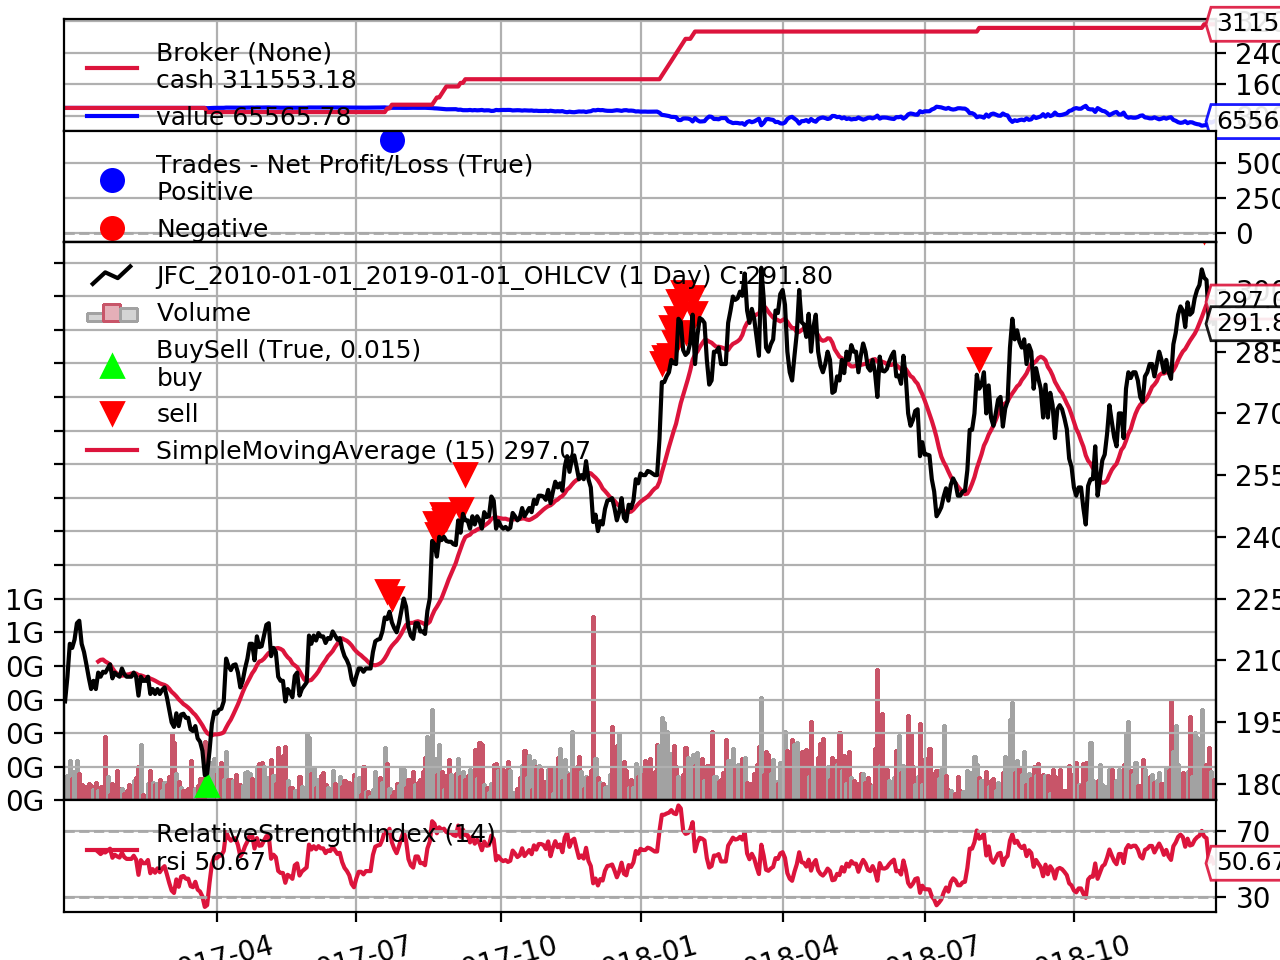

In [3]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime
import os.path
import sys
import backtrader as bt
import backtrader.feeds as btfeed

INIT_CASH = 100000
RSI_PERIOD = 14
COMMISSION_PER_TRANSACTION = 0.06
RSI_UPPER = 70
RSI_LOWER = 30
DATA_FILE = 'data/JFC_2010-01-01_2019-01-01_OHLCV.csv'

class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=15)
        self.rsi = bt.indicators.RelativeStrengthIndex(period=RSI_PERIOD)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])
        print('rsi:', self.rsi[0])
        if self.order:
            return

        if not self.position:
            if (self.rsi[0] < RSI_LOWER):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                # Take a 10% long position every time it's a buy signal
                # "size" refers to the number of stocks to purchase
                self.order = self.buy(size=int((INIT_CASH / self.dataclose[0]) * 0.1))

        else:
            if (self.rsi[0] > RSI_UPPER):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                # Sell a 5% sell position whenever it's down
                # "size" refers to the number of stocks to purchase
                self.order = self.sell(size=int((INIT_CASH / self.dataclose[0]) * 0.1))


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)
    cerebro.broker.setcommission(commission=COMMISSION_PER_TRANSACTION)

    data = btfeed.GenericCSVData(
        dataname=DATA_FILE,

        fromdate=datetime.datetime(2017, 1, 1),
        todate=datetime.datetime(2019, 1, 1),

        nullvalue=0.0,

        dtformat=('%Y-%m-%d'),

        datetime=0,
        open=1,
        high=2,
        low=3,
        close=4,
        volume=5,
        openinterest=-1
    )
    cerebro.adddata(data)
    cerebro.broker.setcash(INIT_CASH)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(figsize=(30, 15))